# **ARIMA**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/PTDLKD

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/PTDLKD


### *Thêm thư viện*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

#### *Tiền xử lý dữ liệu*

In [3]:
def load_crypto(filepath):
    df = pd.read_csv(filepath)
    df = df[['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']]

    for col in ['Price']:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False).astype(float)

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    return df

#### *Kiểm tra tính dừng và lấy sai phân*

In [4]:
def check_stationarity(series):
    d = 0
    while d < 3:
        result = adfuller(series)
        if result[1] < 0.05:
            return d
        series = series.diff().dropna()
        d += 1
    return d

#### *Xác định p, q từ biểu đồ ACF/PACF (vẽ thủ công)*

In [5]:
def plot_acf_pacf(series, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(series, ax=axes[0], lags=40)
    plot_pacf(series, ax=axes[1], lags=40)
    fig.suptitle(title)
    plt.show()

#### *Train ARIMA & dự đoán*

In [6]:
def train_arima(series, order, forecast_steps):
    model = ARIMA(series, order=order)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=forecast_steps)
    return forecast

#### *Vẽ biểu đồ dự đoán*

In [ ]:
# Thay thế cell plot_forecasts (cell a99fdefe)

def plot_forecasts_with_validation(full_series, train_series, test_series, test_forecast, forecasts_dict, title):
    """Vẽ biểu đồ với cả validation và prediction"""
    plt.figure(figsize=(16, 8))
    
    # Vẽ dữ liệu train
    plt.plot(train_series.index, train_series.values, label='Dữ liệu train', color='blue')
    
    # Vẽ dữ liệu test thực tế
    if len(test_series) > 0:
        plt.plot(test_series.index, test_series.values, label='Dữ liệu test thực tế', color='green')
    
    # Vẽ dự đoán trên tập test
    if test_forecast is not None:
        plt.plot(test_series.index, test_forecast, label='Dự đoán test', color='orange', linestyle='--')
    
    # Vẽ dự đoán tương lai
    last_date = full_series.index[-1]
    colors = ['red', 'purple', 'brown']
    
    for i, (days, forecast) in enumerate(forecasts_dict.items()):
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days, freq='D')
        plt.plot(future_dates, forecast, label=f'Dự đoán {days} ngày', 
                color=colors[i % len(colors)], linestyle='--', linewidth=2)
    
    plt.title(title)
    plt.xlabel("Ngày")
    plt.ylabel("Giá")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### *Cải tiến*

In [ ]:
# Thêm cell mới - Import thêm và function cải tiến

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Sửa function find_best_arima_order trong cell b278912f

def find_best_arima_order(series, max_p=3, max_q=3, max_d=2):
    """Tự động tìm tham số ARIMA tối ưu bằng AIC"""
    best_aic = float('inf')
    best_order = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                except:
                    continue
    
    # Nếu không tìm được tham số tối ưu, dùng mặc định
    if best_order is None:
        print("Không tìm được tham số tối ưu, sử dụng (1,1,1)")
        best_order = (1, 1, 1)
        try:
            model = ARIMA(series, order=best_order)
            fitted_model = model.fit()
            best_aic = fitted_model.aic
        except:
            best_aic = float('inf')
    
    return best_order, best_aic

# function validate_model 

def validate_model(train_series, test_series, order):
    """Đánh giá mô hình trên tập test"""
    if len(test_series) == 0:
        return None, None, None, None
    
    try:
        model = ARIMA(train_series, order=order)
        fitted_model = model.fit()
        
        forecast = fitted_model.forecast(steps=len(test_series))
        
        mae = mean_absolute_error(test_series, forecast)
        rmse = np.sqrt(mean_squared_error(test_series, forecast))
        mape = np.mean(np.abs((test_series - forecast) / test_series)) * 100
        
        return mae, rmse, mape, forecast
    except Exception as e:
        print(f"Lỗi trong validation: {e}")
        return None, None, None, None

#### **BITCOIN**


 BITCOIN - Tỷ lệ 8:2 - d = 1


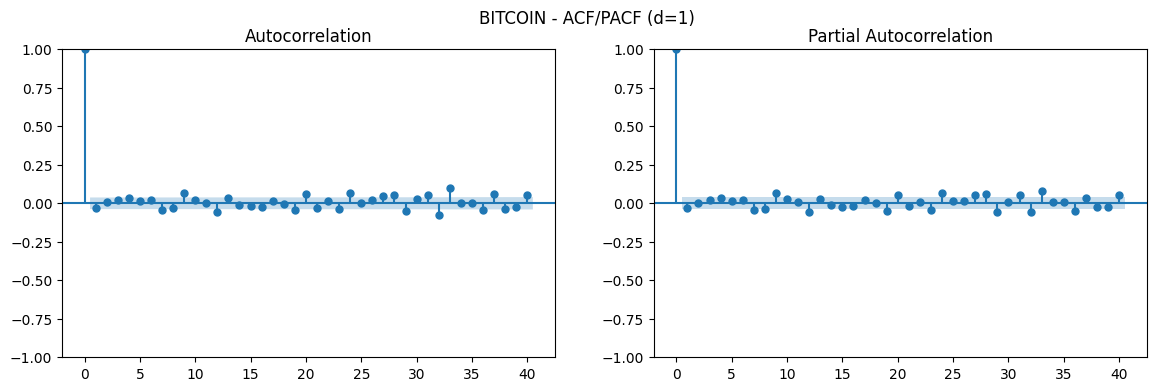

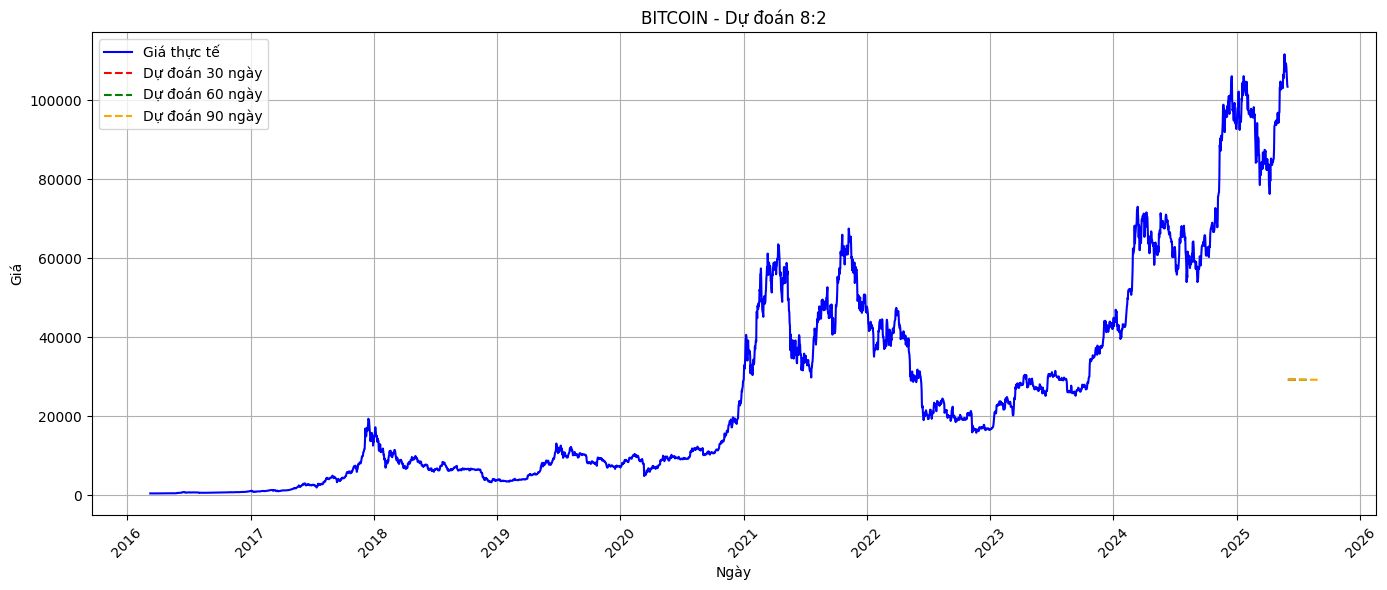


 BITCOIN - Tỷ lệ 7:3 - d = 1


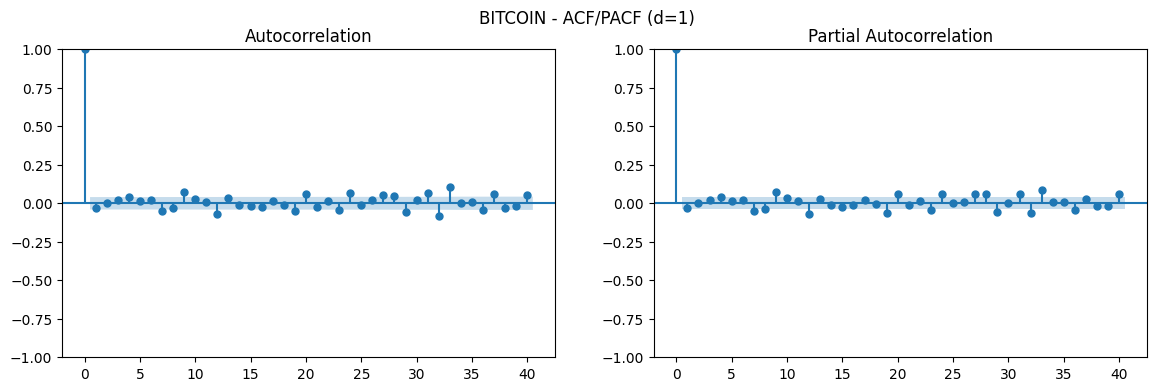

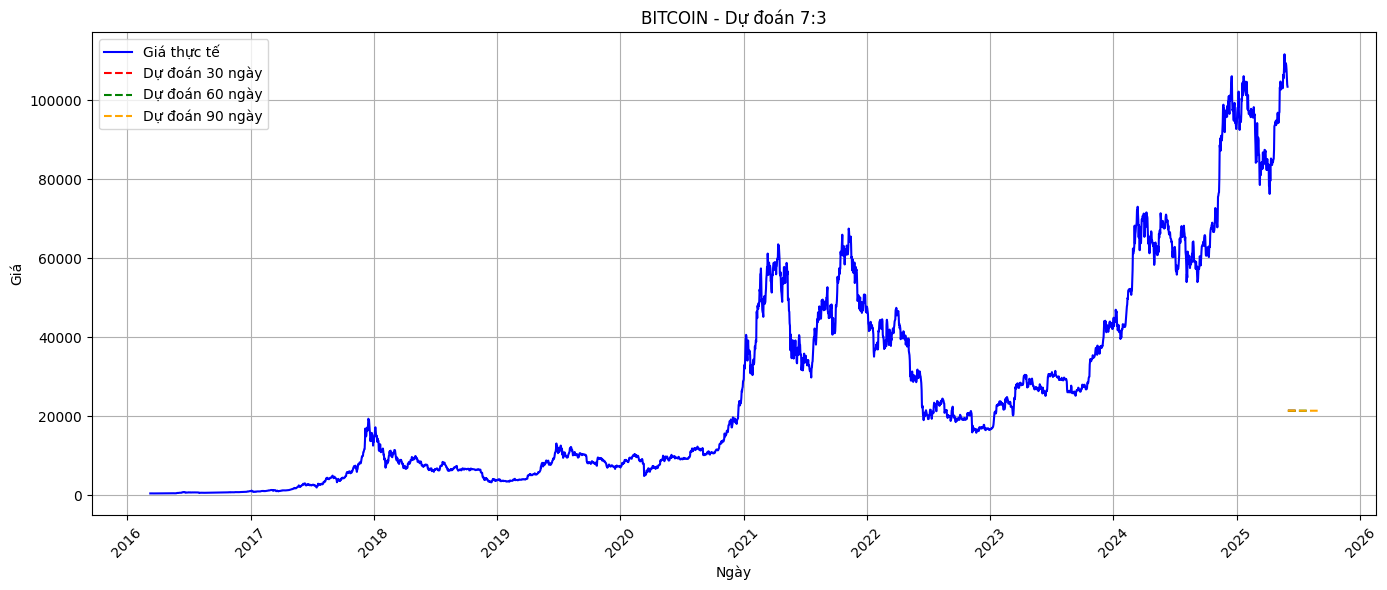


 BITCOIN - Tỷ lệ 9:1 - d = 1


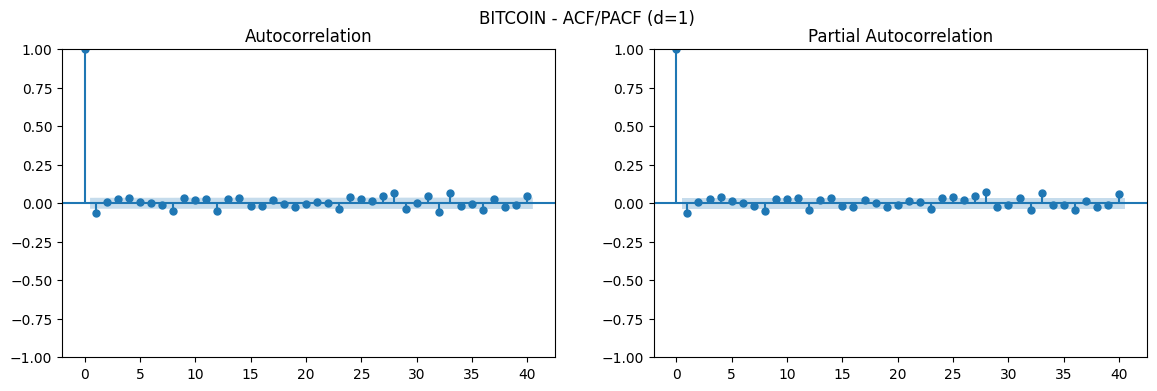

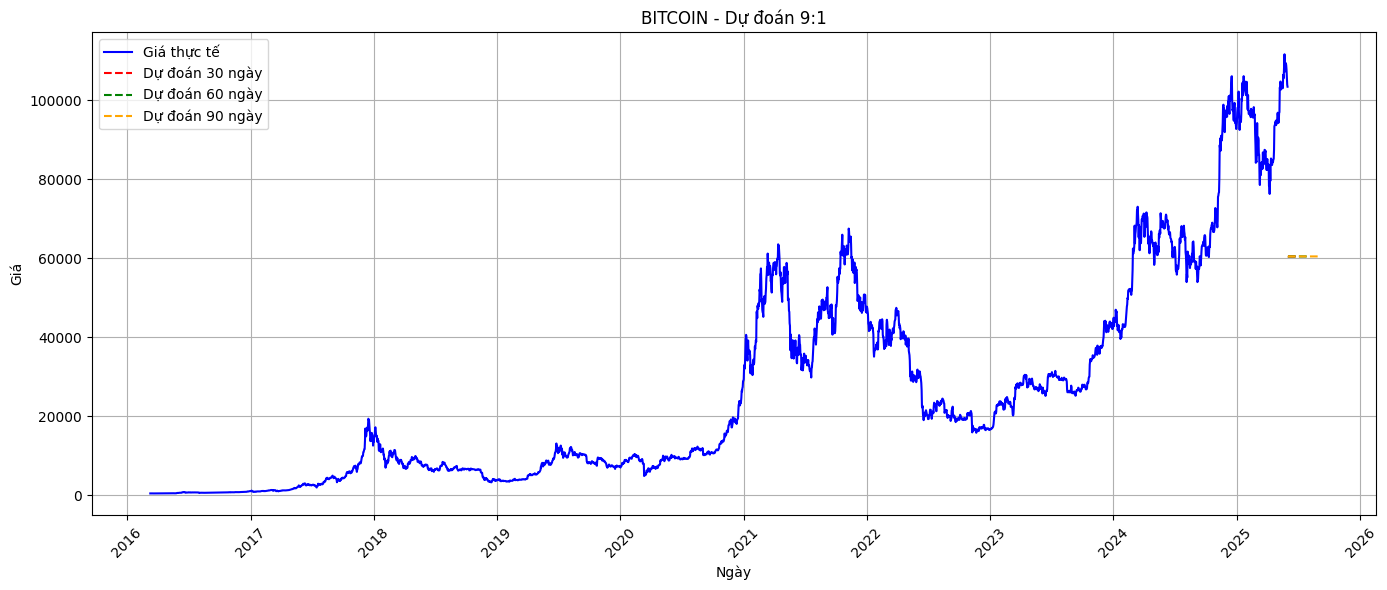

In [ ]:
# Thay thế cell BITCOIN

ratios = [0.8, 0.7, 0.9]
forecast_days_list = [30, 60, 90]
BTC = load_crypto('Bitcoin Historical Data.csv')
price_series = BTC['Price']

for ratio in ratios:
    print(f"\n{'='*50}")
    print(f"BITCOIN - Tỷ lệ {int(ratio*10)}:{10-int(ratio*10)}")
    print(f"{'='*50}")
    
    train_len = int(len(price_series) * ratio)
    train_series = price_series[:train_len]
    test_series = price_series[train_len:]
    
    # Tự động tìm tham số tối ưu
    print("Đang tìm tham số ARIMA tối ưu...")
    best_order, best_aic = find_best_arima_order(train_series)
    print(f"Tham số tối ưu: {best_order}, AIC: {best_aic:.2f}")
    
    # Validation trên tập test
    if len(test_series) > 0:
        mae, rmse, mape, test_forecast = validate_model(train_series, test_series, best_order)
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        test_forecast = None
    
    # Vẽ ACF/PACF với tham số tối ưu
    d = best_order[1]
    diff_series = train_series.diff(d).dropna() if d > 0 else train_series
    plot_acf_pacf(diff_series, f"BITCOIN - ACF/PACF (p={best_order[0]}, d={d}, q={best_order[2]})")
    
    # Dự đoán tương lai
    forecasts = {}
    for forecast_days in forecast_days_list:
        forecast = train_arima(train_series, order=best_order, forecast_steps=forecast_days)
        forecasts[forecast_days] = forecast
    
    # Vẽ biểu đồ với validation
    plot_forecasts_with_validation(price_series, train_series, test_series, 
                                 test_forecast, forecasts, 
                                 f"BITCOIN - Dự đoán {int(ratio*10)}:{10-int(ratio*10)}")

#### **ETHEREUM**


 ETHEREUM - Tỷ lệ 8:2 - d = 1


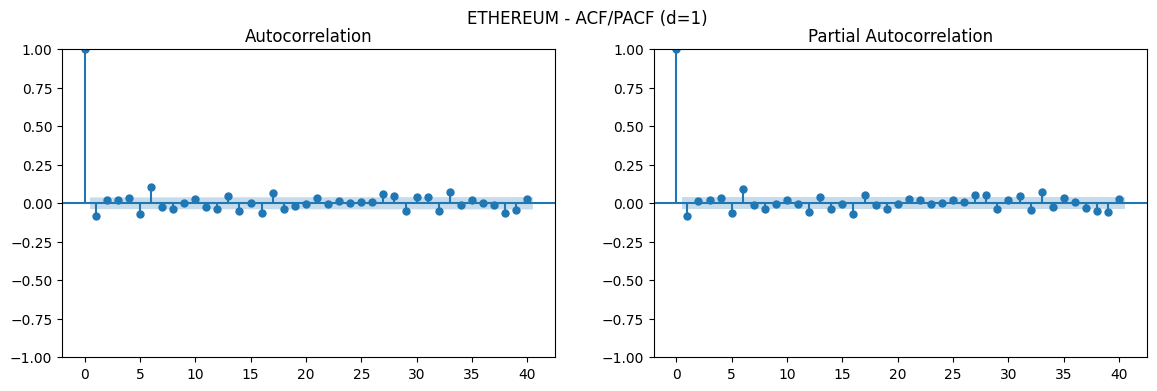

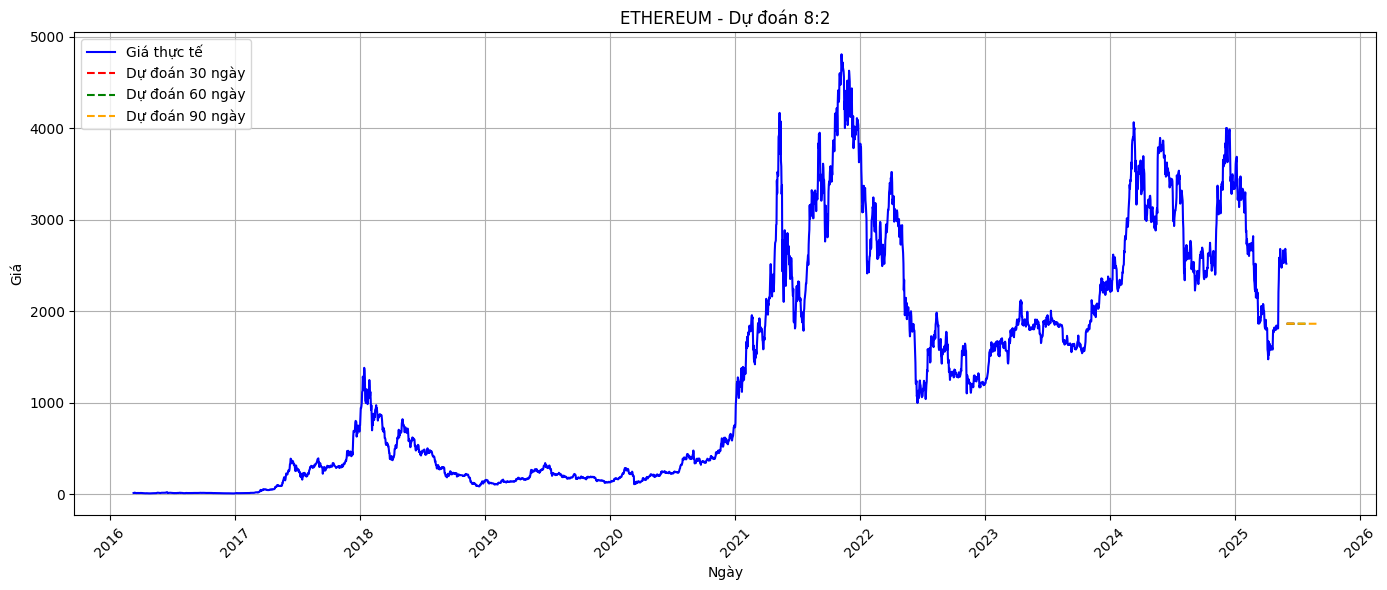


 ETHEREUM - Tỷ lệ 7:3 - d = 1


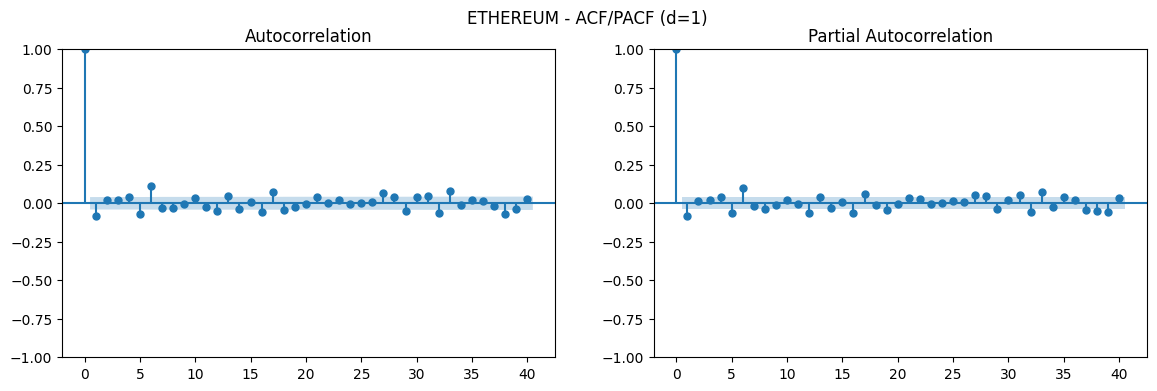

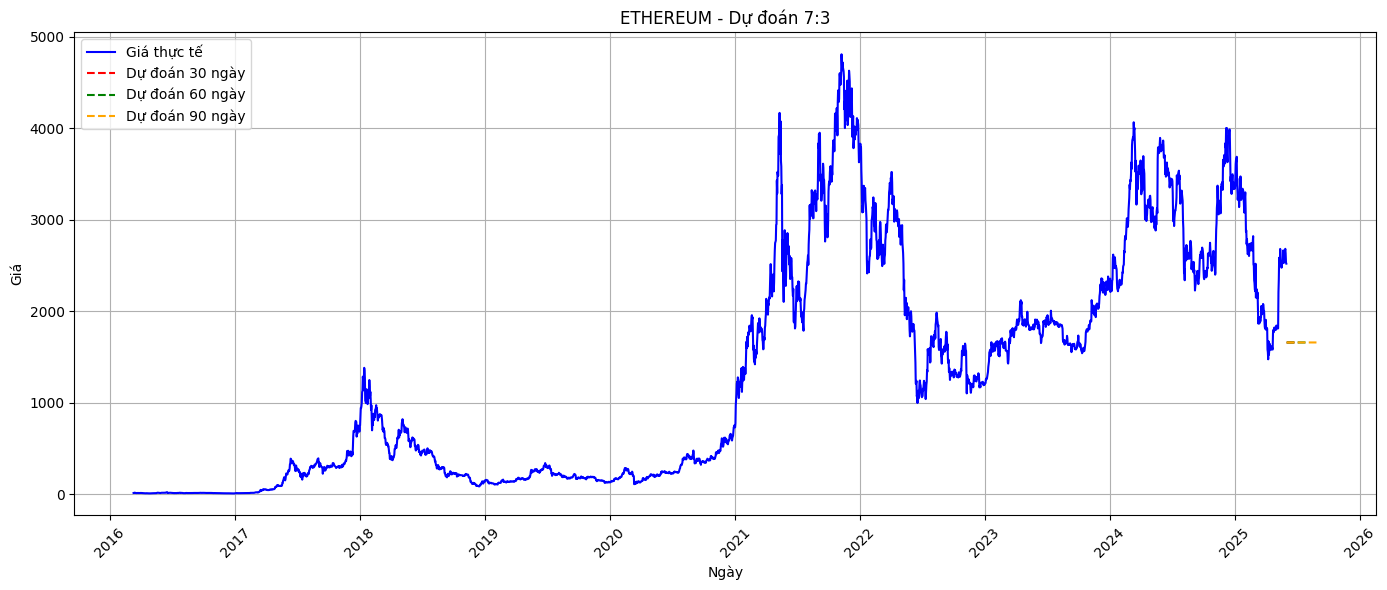


 ETHEREUM - Tỷ lệ 9:1 - d = 1


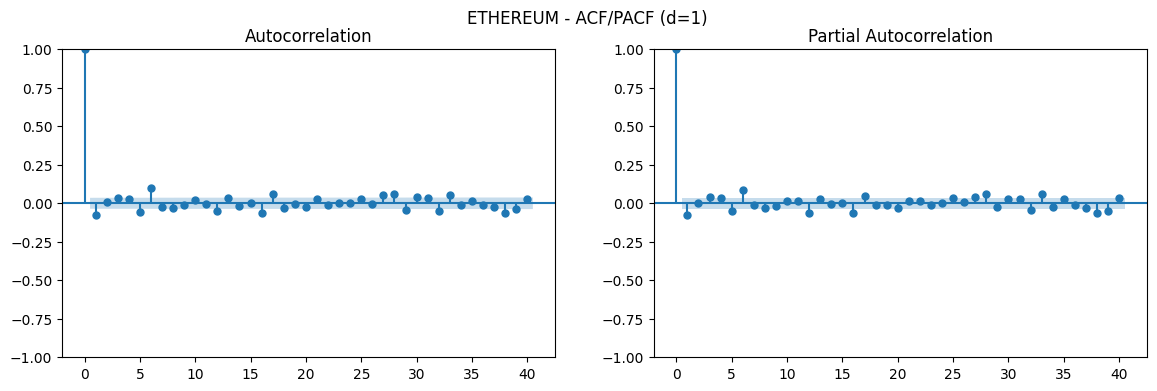

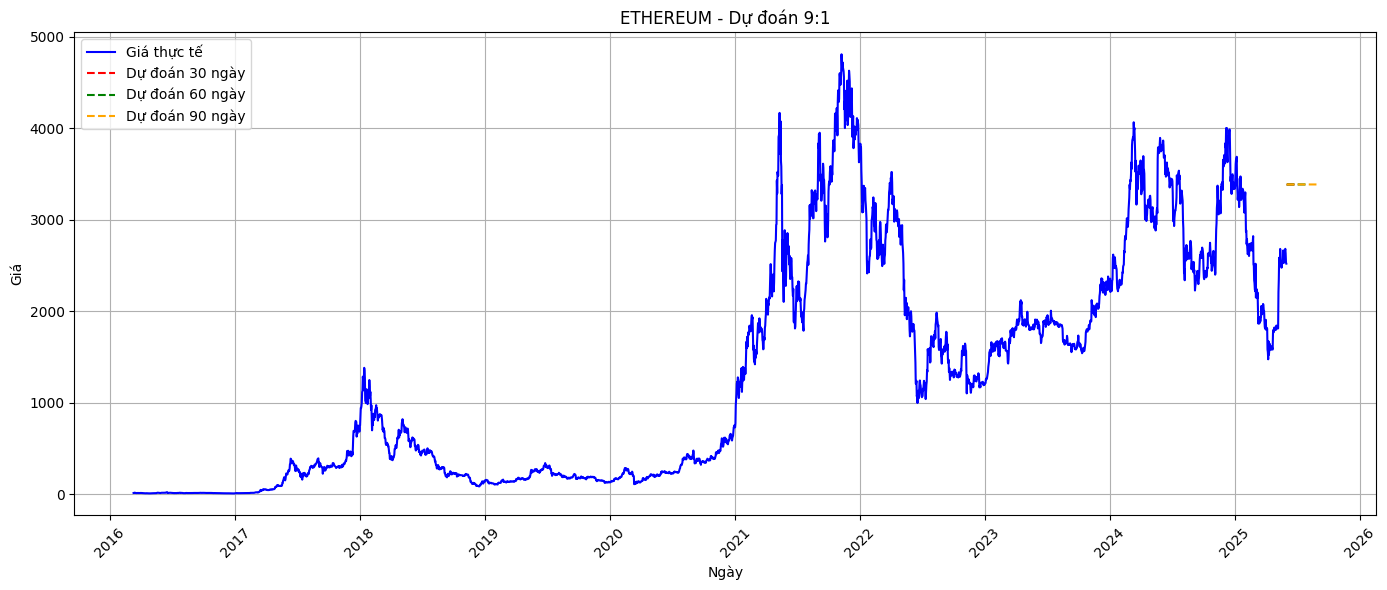

In [ ]:
# Thay thế cell ETHEREUM

ratios = [0.8, 0.7, 0.9]
forecast_days_list = [30, 60, 90]
ETH = load_crypto('Ethereum Historical Data.csv')
price_series = ETH['Price']

for ratio in ratios:
    print(f"\n{'='*50}")
    print(f"ETHEREUM - Tỷ lệ {int(ratio*10)}:{10-int(ratio*10)}")
    print(f"{'='*50}")
    
    train_len = int(len(price_series) * ratio)
    train_series = price_series[:train_len]
    test_series = price_series[train_len:]
    
    print("Đang tìm tham số ARIMA tối ưu...")
    best_order, best_aic = find_best_arima_order(train_series)
    print(f"Tham số tối ưu: {best_order}, AIC: {best_aic:.2f}")
    
    if len(test_series) > 0:
        mae, rmse, mape, test_forecast = validate_model(train_series, test_series, best_order)
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        test_forecast = None
    
    d = best_order[1]
    diff_series = train_series.diff(d).dropna() if d > 0 else train_series
    plot_acf_pacf(diff_series, f"ETHEREUM - ACF/PACF (p={best_order[0]}, d={d}, q={best_order[2]})")
    
    forecasts = {}
    for forecast_days in forecast_days_list:
        forecast = train_arima(train_series, order=best_order, forecast_steps=forecast_days)
        forecasts[forecast_days] = forecast
    
    plot_forecasts_with_validation(price_series, train_series, test_series, 
                                 test_forecast, forecasts, 
                                 f"ETHEREUM - Dự đoán {int(ratio*10)}:{10-int(ratio*10)}")

#### **XRP**


 XRP - Tỷ lệ 8:2 - d = 0


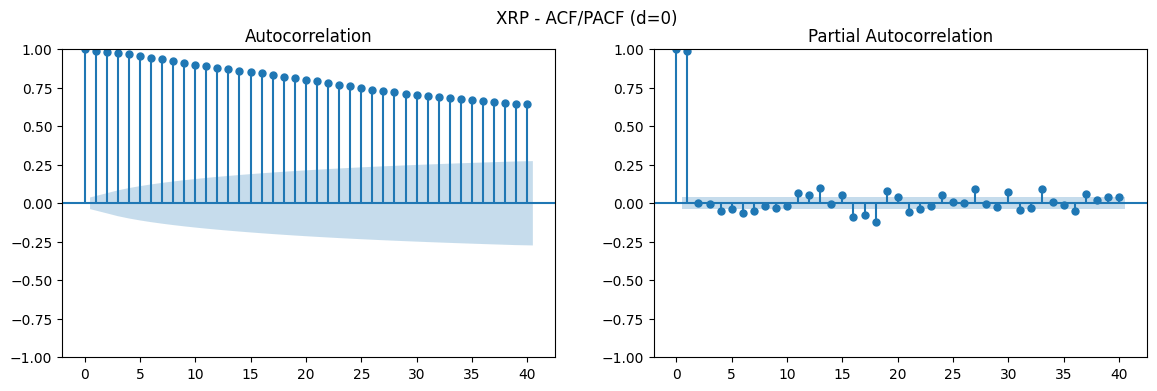

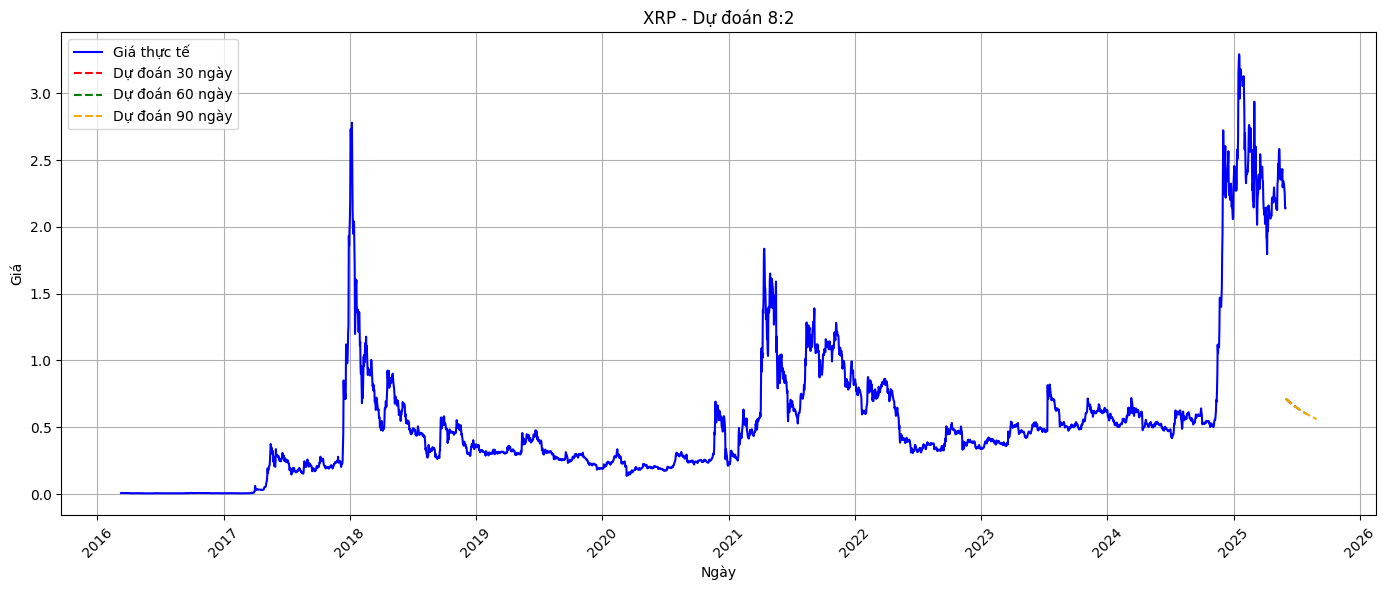


 XRP - Tỷ lệ 7:3 - d = 0


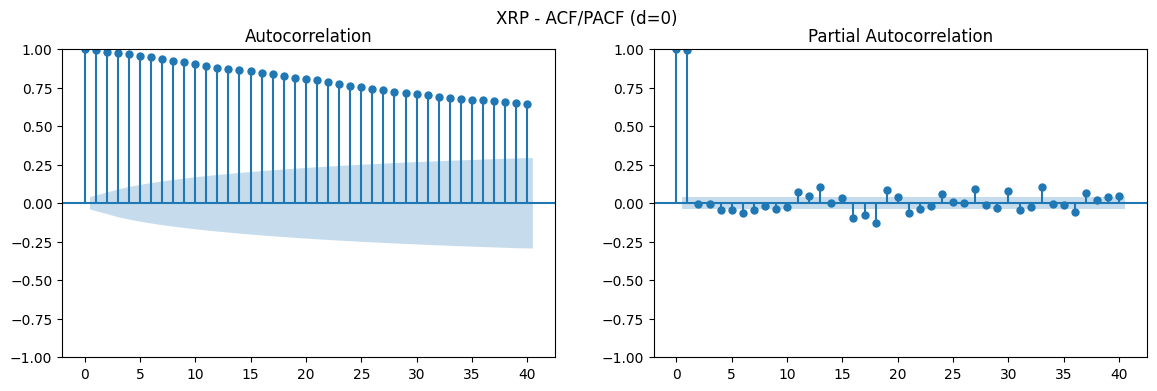

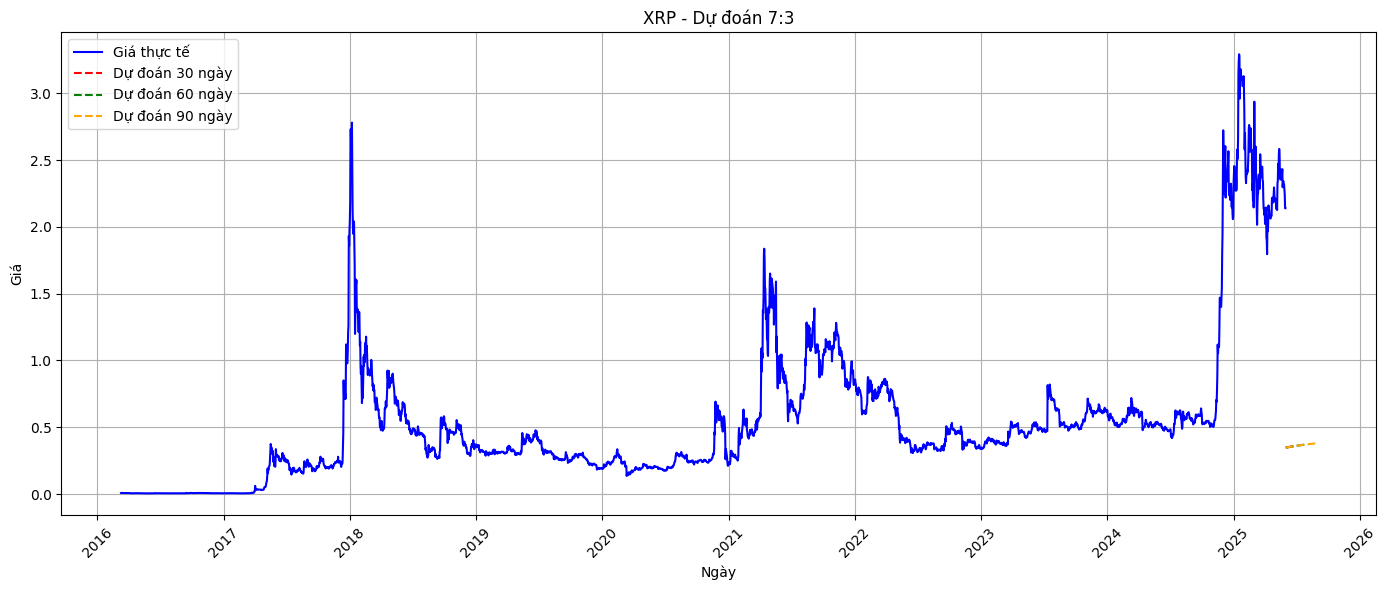


 XRP - Tỷ lệ 9:1 - d = 0


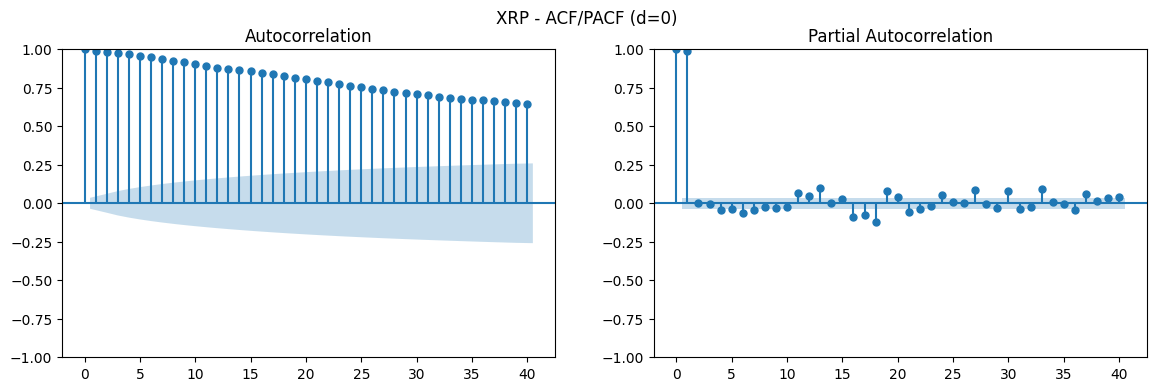

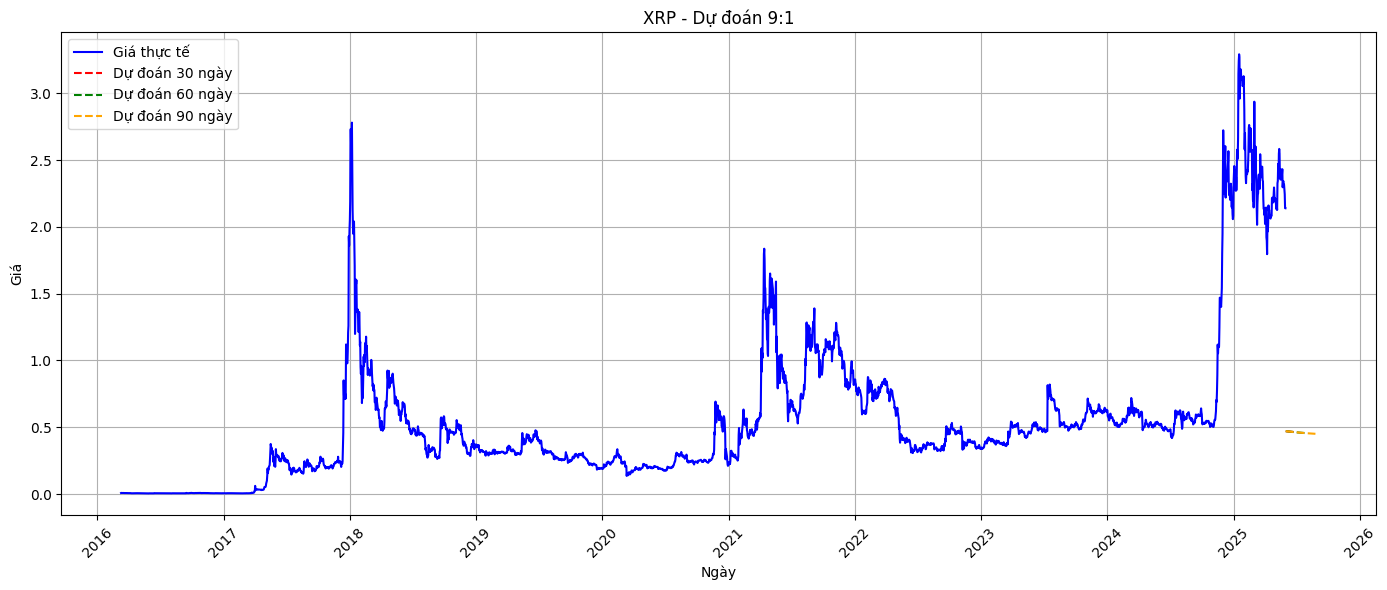

In [ ]:
# Thay thế cell XRP

ratios = [0.8, 0.7, 0.9]
forecast_days_list = [30, 60, 90]
XRP = load_crypto('XRP Historical Data.csv')
price_series = XRP['Price']

for ratio in ratios:
    print(f"\n{'='*50}")
    print(f"XRP - Tỷ lệ {int(ratio*10)}:{10-int(ratio*10)}")
    print(f"{'='*50}")
    
    train_len = int(len(price_series) * ratio)
    train_series = price_series[:train_len]
    test_series = price_series[train_len:]
    
    print("Đang tìm tham số ARIMA tối ưu...")
    best_order, best_aic = find_best_arima_order(train_series)
    print(f"Tham số tối ưu: {best_order}, AIC: {best_aic:.2f}")
    
    if len(test_series) > 0:
        mae, rmse, mape, test_forecast = validate_model(train_series, test_series, best_order)
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        test_forecast = None
    
    d = best_order[1]
    diff_series = train_series.diff(d).dropna() if d > 0 else train_series
    plot_acf_pacf(diff_series, f"XRP - ACF/PACF (p={best_order[0]}, d={d}, q={best_order[2]})")
    
    forecasts = {}
    for forecast_days in forecast_days_list:
        forecast = train_arima(train_series, order=best_order, forecast_steps=forecast_days)
        forecasts[forecast_days] = forecast
    
    plot_forecasts_with_validation(price_series, train_series, test_series, 
                                 test_forecast, forecasts, 
                                 f"XRP - Dự đoán {int(ratio*10)}:{10-int(ratio*10)}")